# 11.2 Preparing text data

*Vectorizing* text is the process of transforming
text into numeric tensors. Text vectorization processes come in many shapes and forms, but they all follow the same template:
- First, you standardize the text to make it easier to process, such as by converting it to lowercase or removing punctuation.
- You split the text into units (called tokens), such as characters, words, or groups of words. This is called tokenization.
- You convert each such token into a numerical vector. This will usually involve first indexing all tokens present in the data.

Let’s review each of these steps.

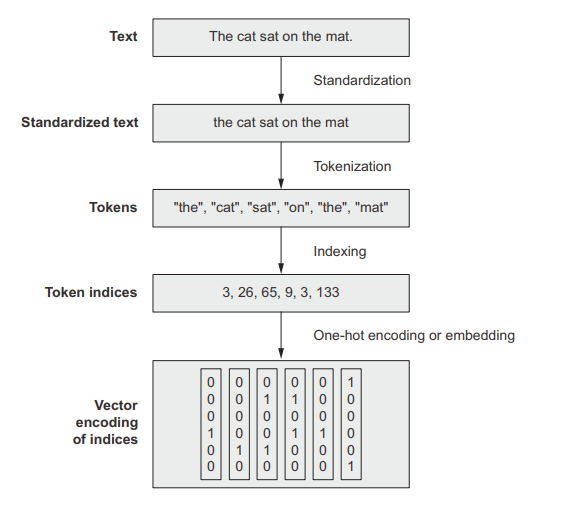

## 11.2.1 Text standardization

Consider these two sentences:
- “sunset came. i was staring at the Mexico sky. Isnt nature splendid??”
- “Sunset came; I stared at the México sky. Isn’t nature splendid?”
They’re very similar—in fact, they’re almost identical. Yet, if you were to convert them
to byte strings, they would end up with very different representations, because “i” and
“I” are two different characters, “Mexico” and “México” are two different words, “isnt”
isn’t “isn’t,” and so on. A machine learning model doesn’t know a priori that “i” and
“I” are the same letter, that “é” is an “e” with an accent, or that “staring” and “stared”
are two forms of the same verb.

Text standardization is a basic form of feature engineering that aims to erase
encoding differences that you don’t want your model to have to deal with. It’s not
exclusive to machine learning, either—you’d have to do the same thing if you were
building a search engine.

 One of the simplest and most widespread standardization schemes is “convert to
lowercase and remove punctuation characters.” Our two sentences would become
- “sunset came i was staring at the mexico sky isnt nature splendid”
- “sunset came i stared at the méxico sky isnt nature splendid”

Much closer already. Another common transformation is to convert special characters
to a standard form, such as replacing “é” with “e,” “æ” with “ae,” and so on. Our token
“méxico” would then become “mexico”.

Lastly, a much more advanced standardization pattern that is more rarely used in a
machine learning context is *stemming*: converting variations of a term (such as different conjugated forms of a verb) into a single shared representation, like turning
“caught” and “been catching” into “[catch]” or “cats” into “[cat]”. With stemming,
“was staring” and “stared” would become something like “[stare]”, and our two similar
sentences would finally end up with an identical encoding:
- “sunset came i [stare] at the mexico sky isnt nature splendid”

With these standardization techniques, your model will require less training data and
will generalize better—it won’t need abundant examples of both “Sunset” and “sunset” to learn that they mean the same thing, and it will be able to make sense of “México” even if it has only seen “mexico” in its training set. Of course, standardization may
also erase some amount of information, so always keep the context in mind: for
instance, if you’re writing a model that extracts questions from interview articles, it
should definitely treat “?” as a separate token instead of dropping it, because it’s a useful signal for this specific task. 

## 11.2.2 Text splitting (tokenization)

Once your text is standardized, you need to break it up into units to be vectorized
(tokens), a step called tokenization. You could do this in three different ways:
- *Word-level tokenization*—Where tokens are space-separated (or punctuationseparated) substrings. A variant of this is to further split words into subwords
when applicable—for instance, treating “staring” as “star+ing” or “called” as
“call+ed.”
- *N-gram tokenization*—Where tokens are groups of N consecutive words. For
instance, “the cat” or “he was” would be 2-gram tokens (also called bigrams).
- *Character-level tokenization*—Where each character is its own token. In practice,
this scheme is rarely used, and you only really see it in specialized contexts, like
text generation or speech recognition.

In general, you’ll always use either word-level or N-gram tokenization. There are two
kinds of text-processing models: those that care about word order, called *sequence models*, and those that treat input words as a set, discarding their original order, called
*bag-of-words models*. If you’re building a sequence model, you’ll use word-level tokenization, and if you’re building a bag-of-words model, you’ll use N-gram tokenization.
N-grams are a way to artificially inject a small amount of local word order information
into the model. Throughout this chapter, you’ll learn more about each type of model
and when to use them.

**Understanding N-grams and bag-of-words**

Word N-grams are groups of N (or fewer) consecutive words that you can extract from
a sentence. The same concept may also be applied to characters instead of words.

Here’s a simple example. Consider the sentence “the cat sat on the mat.” It may be
decomposed into the following set of 2-grams:

```
{"the", "the cat", "cat", "cat sat", "sat",
 "sat on", "on", "on the", "the mat", "mat"}
 ```
 
 It may also be decomposed into the following set of 3-grams:
 ```
 {"the", "the cat", "cat", "cat sat", "the cat sat",
 "sat", "sat on", "on", "cat sat on", "on the",
 "sat on the", "the mat", "mat", "on the mat"}
 ```
 
 Such a set is called a *bag-of-2-grams* or *bag-of-3-grams*, respectively. The term “bag”
here refers to the fact that you’re dealing with a set of tokens rather than a list or
sequence: the tokens have no specific order. This family of tokenization methods is
called *bag-of-words* (or *bag-of-N-grams*).

Because bag-of-words isn’t an order-preserving tokenization method (the tokens generated are understood as a set, not a sequence, and the general structure of the sentences is lost), it tends to be used in shallow language-processing models rather than in deep learning models. Extracting N-grams is a form of feature engineering, and
deep learning sequence models do away with this manual approach, replacing it with
hierarchical feature learning. One-dimensional convnets, recurrent neural networks,
and Transformers are capable of learning representations for groups of words and
characters without being explicitly told about the existence of such groups, by looking
at continuous word or character sequences. 

## 11.2.3 Vocabulary indexing

Once your text is split into tokens, you need to encode each token into a numerical
representation. You could potentially do this in a stateless way, such as by hashing each
token into a fixed binary vector, but in practice, the way you’d go about it is to build
an index of all terms found in the training data (the “vocabulary”), and assign a
unique integer to each entry in the vocabulary.

``` python
vocabulary = {}
for text in dataset:
    text = standardize(text)
    tokens = tokenize(text)
    for token in tokens:
        if token not in vocabulary:
            vocabulary[token] = len(vocabulary)
```

You can then convert that integer into a vector encoding that can be processed by a
neural network, like a one-hot vector:
``` python
def one_hot_encode_token(token):
    vector = np.zeros((len(vocabulary),))
    token_index = vocabulary[token]
    vector[token_index] = 1
    return vector
```

Note that at this step it’s common to restrict the vocabulary to only the top 20,000 or
30,000 most common words found in the training data. Any text dataset tends to feature an extremely large number of unique terms, most of which only show up once or
twice—indexing those rare terms would result in an excessively large feature space,
where most features would have almost no information content.

There’s an important detail here that we shouldn’t overlook: when we look
up a new token in our vocabulary index, it may not necessarily exist. Your training
data may not have contained any instance of the word “cherimoya” (or maybe you
excluded it from your index because it was too rare), so doing `token_index =
vocabulary["cherimoya"]` may result in a `KeyError`. To handle this, you should use
an “out of vocabulary” index (abbreviated as *OOV index*)—a catch-all for any token
that wasn’t in the index. It’s usually index 1: you’re actually doing `token_index =
vocabulary.get(token, 1)`. When decoding a sequence of integers back into words,
you’ll replace 1 with something like “[UNK]” (which you’d call an “OOV token”).

 “Why use 1 and not 0?” you may ask. That’s because 0 is already taken. There are
two special tokens that you will commonly use: the OOV token (index 1), and the
*mask token* (index 0). While the OOV token means “here was a word we did not recognize,” the mask token tells us “ignore me, I’m not a word.” You’d use it in particular to
pad sequence data: because data batches need to be contiguous, all sequences in a
batch of sequence data must have the same length, so shorter sequences should be
padded to the length of the longest sequence. If you want to make a batch of data with
the sequences `[5, 7, 124, 4, 89]` and `[8, 34, 21]`, it would have to look like this:

```
[[5, 7, 124, 4, 89]
 [8, 34, 21, 0, 0]]
 ```
 
The batches of integer sequences for the IMDB dataset that you worked with in chapters 4 and 5 were padded with zeros in this way. 

## 11.2.4 Using the TextVectorization layer

Every step introduced so far would be very easy to implement in pure Python.
Maybe you could write something like this:

In [2]:
import string

class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text 
                       if char not in string.punctuation)
    
    def tokenize(self, text):
        text = self.standardize(text)
        return text.split()
    
    def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict((v, k) for k, v in self.vocabulary.items())
        
    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens]
    
    def decode(self, int_sequence):
        return " ".join(self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)
    
vectorizer = Vectorizer()
dataset = [
 "I write, erase, rewrite",
 "Erase again, and then",
 "A poppy blooms.",
]
vectorizer.make_vocabulary(dataset)

In [3]:
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = vectorizer.encode(test_sentence)
print(encoded_sentence)

[2, 3, 5, 7, 1, 5, 6]


In [4]:
decoded_sentence = vectorizer.decode(encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


However, using something like this wouldn’t be very performant. In practice, you’ll
work with the Keras `TextVectorization` layer, which is fast and efficient and can be
dropped directly into a `tf.data` pipeline or a Keras model.
 This is what the `TextVectorization` layer looks like:

In [ ]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(
    # Configures the layer to return sequences of words encoded as integer indices. 
    # There are several other output modes available, which you will see in action in a bit.
    output_mode="int",
)

By default, the `TextVectorization` layer will use the setting “convert to lowercase and
remove punctuation” for text standardization, and “split on whitespace” for tokenization. But importantly, you can provide custom functions for standardization and tokenization, which means the layer is flexible enough to handle any use case. Note that
such custom functions should operate on `tf.string` tensors, not regular Python
strings! For instance, the default layer behavior is equivalent to the following:

In [ ]:
import re
import string
import tensorflow as tf

def custom_standardization_fn(string_tensor):
    # Convert strings to lowercase.
    lowercase_string = tf.strings.lower(string_tensor)
    # Replace punctuation characters with the empty string.
    return tf.strings.regex_replace(
        lowercase_string, f"[{re.escape(string.punctuation)}]", "")